In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

In [2]:
'''
labels are just a single number, we vectorize them to have the same shape as the output vector of the nn
'''
def vectorize_label(y):
    if y == 10:
        y=0
    label = np.zeros(10)
    #print(type(y))
    label[y] = 1
    #print(label)
    
    return np.reshape(label,(10,1))

### reading the data

In [3]:
X = []
y = []
data_dir = "data/"
data_file = "image_0.txt"
label_file = "label.txt"

X = [[float(pix) for pix in  img.split(",") ] for img in open(data_dir+data_file)]
y = [vectorize_label(int(label)) for label in open(data_dir+label_file)]

X = [np.reshape(x,(400,1)) for x in X]


data = list(zip(X,y)) # so that we can shuffle the data

print(len(X))
print(len(y))

5000
5000


### train test split

In [4]:
train_indexes = list()
test_indexes = list()

threshold = 0.7

for i in range(len(X)):
    if np.random.uniform(0,1) < threshold:
        train_indexes += [i]
    else:
        test_indexes += [i]

X_train = [np.array(X[i]) for i in train_indexes ]
y_train = [y[i] for i in train_indexes ]

X_test = [np.array(X[i]) for i in test_indexes ]
y_test = [y[i] for i in test_indexes ]


print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

3495 3495
1505 1505


In [5]:
train_data = list(zip(X_train,y_train))
test_data = list(zip(X_test,y_test))

## some important functions

In [6]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

In [7]:
def sigmoid_prime(z):
    return (sigmoid(z)*(1-sigmoid(z)))

In [14]:
size = 20
biases = [np.random.randn(size, 1) ]
biases

[array([[-1.39115788],
        [ 0.19235115],
        [-0.55016042],
        [-0.95371744],
        [-0.15396963],
        [-0.27704242],
        [ 0.31801086],
        [ 0.55105612],
        [-0.71504383],
        [ 0.5787017 ],
        [ 0.36332098],
        [ 0.85253574],
        [ 1.6437645 ],
        [-1.11053181],
        [-0.66724759],
        [-0.06309689],
        [ 0.8448941 ],
        [-0.17404087],
        [-0.87234737],
        [ 0.77746428]])]

### Neural network class

### important equations for performing backpropagation

Then, we define the activation of the J th neuron in layer l as:
$$ a^{l}_j = \sigma\left( \sum_k w^{l}_{jk} a^{l-1}_k + b^l_j \right) $$


Next, we will define a total of 4 equations that will help us calculate the partial derivatives necessary to perform backropagation. 

1) $$  \delta^L_j = \frac{\partial C}{\partial a^L_j} \sigma'(z^L_j) $$

where delta represents the error derivative in the output layer L

We can also show this function in a simpler notation with: $ \delta^L = \nabla_a C \odot \sigma'(z^L) $ where $\odot$ is the hadamard product (element-wise product)

2) $$\delta^l = ((w^{l+1})^T \delta^{l+1}) \odot \sigma'(z^l)$$

Where the error derivative from any layer relates to the layers further down the network. The terms $w^{l+1})^T \delta^{l+1}$ can be intuitively understood as propagating backwards the prediction error

3) $$\frac{\partial C}{\partial b^l_j} = \delta^l_j $$

The rate of change of the cost with respects to the biases in the network


4)  $$\frac{\partial C}{\partial w^l_{jk}} = a^{l-1}_k \delta^l_j$$

The rate of change of the cost with respects to the weights in the network.

In [8]:
class Neural_Network(object):
    
    #constructor
    def __init__(self,layer_sizes):
        self.num_layers = len(layer_sizes)
        self.sizes = layer_sizes
        #init weights and biases, done accroding to a normal distrib of mean 0 and sd 1
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        #weights are divided by the squre root of the dimension of the second layer to limit the variance
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        
    
    #feedforward function to pass forward the input through the network and return the output vector
    def feedforward(self, a):
        for w,b in zip(self.weights,self.biases):
            a = sigmoid(np.dot(w,a))
        return a
    
    #cost function of our network which is the SSE
    def cost(self,y_pred,y):
        sse = 0
        for pred,true in zip(y_pred,y):
            sse += (pred-true)**2
        return sse/2
    #derivative of cost function
    def cost_prime(self,pred,y):
        return (pred-y)
    
    #evaluates the accuracy of the network after each epoch
    def evaluate(self,test_data):
        preds = [(np.argmax(self.feedforward(x)),np.argmax(y)) for x,y in test_data]
        
        return sum(int(x==y) for (x,y) in preds)
        
    
    
    #actual meat of the class, with the fit functions that uses batch gradient descent to train the network
    def fit(self,train_data,learning_rate,test_data,nb_epochs=1,batch_size=100):
        """
        Fit function for our nn, uses mini_batch stochastic gradient descent for speeding up the training process.
        instead of calculating the cost MSE for all our training examples, we split this into batches which hopefully 
        give us a good enough approximation of the Cost functions derivative
        """
        accuracy = []
        
        
        for epoch in range(nb_epochs):
            #shuffle our data so we get more varied samples 
            random.shuffle(train_data)
            #split our train data into mini batches 
            mini_batches = [train_data[i:i+batch_size] for i in range(0,len(train_data),batch_size)]
            
            
            
            #now we iterate over each batch
            for batch in mini_batches:
                    self.update_batch(batch,learning_rate,epoch)
            
            accuracy.append((self.evaluate(test_data)/len(test_data))*100) 
            print("startig epoch:",epoch, "accuracy:", accuracy[epoch],"%")
            
            
        #plot the accuracy
        plt.plot(range(nb_epochs),accuracy)
    
    def update_batch(self,batch,learning_rate,epoch):
        #arrays to keep track of the gradient values for each weights and bias
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        #iterate over the data in the batch
        for x,y in batch:
            delta_nabla_b,delta_nabla_w = self.backpropagate(x,y)
            
            # sum with previous gradients, we will take an average later
            nabla_b = [nb+dnb for nb,dnb in zip(nabla_b,delta_nabla_b)]
            nabla_w = [nw+dnw for nw,dnw in zip(nabla_w,delta_nabla_w)]
        
        #now we average the changes from earlier and apply thel to the weights
        adjust_eta = learning_rate
        
        self.biases = [b - ((adjust_eta/len(batch)) * nb) for b,nb in zip(self.biases,nabla_b)]
        self.weights = [w - ((adjust_eta/len(batch)) * nw) for w,nw in zip(self.weights,nabla_w)]
        
        
    def backpropagate(self,x,y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        #some arrays to keep track of the data as we go
        #to store activation vectors at each layer
        activations= []
        activations.append(x) #indeed, first activation is the input
        
        #to store weighted sum vectors before activation
        Zs = []
        
        #feed forward part
        a=x
        for w,b in zip(self.weights, self.biases):
            z = np.dot(w,a) + b
            Zs.append(z)
            a = sigmoid(z)
            activations.append(a)
        
        #now we can feed back the error and propagate it through the network
        #first we calculate the error at the very last layer
        delta = self.cost_prime(activations[-1],y) * sigmoid_prime(Zs[-1]) ## see equation 1 above
        
        #use this delta to get the gradient for weights and biases at the last layer
        nabla_b[-1] = delta #see equation 3
        nabla_w[-1] = np.dot(delta,activations[-2].transpose()) # see equation 4, need to transpose to match dimensions
        
        #now we propagate down the other layers
        for l in range(2, self.num_layers):
            delta = np.dot(self.weights[-l+1].transpose(),delta) * sigmoid_prime(Zs[-l]) ## see equation 2
            
            nabla_b[-l] = delta #see equation 3
            nabla_w[-l] = np.dot(delta,activations[-l -1].transpose()) # see equation 4, need to transpose to match dimensions
        
        return nabla_b,nabla_w
        
        
        

In [15]:
nn = Neural_Network([400,30,10])

startig epoch: 0 accuracy: 89.56810631229236 %
startig epoch: 1 accuracy: 89.56810631229236 %
startig epoch: 2 accuracy: 89.5016611295681 %
startig epoch: 3 accuracy: 89.5016611295681 %
startig epoch: 4 accuracy: 89.56810631229236 %
startig epoch: 5 accuracy: 89.63455149501661 %
startig epoch: 6 accuracy: 89.5016611295681 %
startig epoch: 7 accuracy: 89.43521594684385 %
startig epoch: 8 accuracy: 89.5016611295681 %
startig epoch: 9 accuracy: 89.5016611295681 %
startig epoch: 10 accuracy: 89.63455149501661 %
startig epoch: 11 accuracy: 89.63455149501661 %
startig epoch: 12 accuracy: 89.63455149501661 %
startig epoch: 13 accuracy: 89.56810631229236 %
startig epoch: 14 accuracy: 89.56810631229236 %
startig epoch: 15 accuracy: 89.63455149501661 %
startig epoch: 16 accuracy: 89.70099667774086 %
startig epoch: 17 accuracy: 89.63455149501661 %
startig epoch: 18 accuracy: 89.56810631229236 %
startig epoch: 19 accuracy: 89.5016611295681 %
startig epoch: 20 accuracy: 89.56810631229236 %
startig 

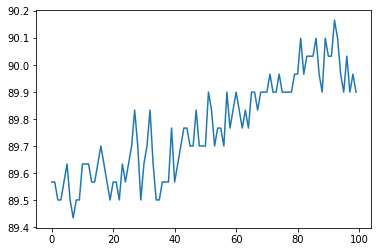

In [18]:
#hyperparams
epochs = 100
batch_size = 100
learning_rate = 0.25

nn.fit(train_data,learning_rate,test_data,epochs,batch_size)